# Subway Data Analysis

## Introduction

The NYC public transportation system - Metro Transit Authority - provides data for download via csv files. Part of the information available are data from the subway turnstiles, containing weekly logs for cumulative entries and exits by turnstile and by subway station during a provided timeframe.





# About this project

The goal of this project is to explore the relationship between data from the NYC Subway turnstiles and the city weather. For this, besides data from the subway, we will also need data from the weather in NYC. 

- Gathering data from the Internet
- Using Statistics for Data Analysis
- Data handling and simple graphics creation with `Pandas`
- Using MapReduce to find out whether on an average people use the subway more when the sky is clear or on rainy days.



## Data Gathering



In [21]:
import urllib.request
from bs4 import BeautifulSoup

#your code here
url = "http://web.mta.info/developers/turnstile.html"
u = urllib.request.urlopen(url)
html = u.read()

soup = BeautifulSoup(html, "html.parser")
links = soup.find_all('a')

#List to store the filenames
filenames = []

for link in links:
    if link.get('href') is not None and '1706' in link.get('href'):
        #print(link.get('href').split('/')[3])
        print("Retreiving file "+link.get('href').split('/')[3]+" from server")
        try:
            urllib.request.urlretrieve("http://web.mta.info/developers/"+str(link.get('href')), link.get('href').split('/')[3])
            filenames.append(link.get('href').split('/')[3]) #Saving all the filenames in a list
            print("File "+link.get('href').split('/')[3]+" downloaded and filename saved in list.")
        except:
            print("Error retreiving "+link.get('href').split('/')[3]+" from the website.")       




Function that takes the list of all names of the file downloaded in previous step and compile them into one single file. There must be only one header line in the output file. 

For example, if file_1 has:
line 1...
line 2...

and the other file, file_2, has:
line 3...
line 4...
line 5...

We must combine file_1 and file_2 into one master file, as follows:

'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn'
line 1...
line 2...
line 3...
line 4...
line 5...


In [22]:
out_file = "Master.txt"

def create_master_turnstile_file(filenames, output_file):
    try:
        with open(output_file, 'w') as master_file:
            master_file.write('C/A,UNIT,SCP,STATION, LINENAME, DIVISION, DATEn,TIMEn,DESCn,ENTRIESn,EXITSn\n')
            for filename in filenames:
                # your code here
                with open(filename,'r') as infile:
                    next(infile)
                    for line in infile:
                        master_file.write(line) #Writing line by line to the master file
        master_file.close()
    except:
        print("Error in creating master file")


print("Master File getting created......")
create_master_turnstile_file(filenames,out_file)
print("Master file "+out_file+" created")



Function that reads the master_file created in the previous step and load it into a Pandas Dataframe. This function can be filtered, so that the Dataframe only has lines where column "DESCn" has the value "Regular".

For example, if the Pandas Dataframe looks like this:
    
    ,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn
    0,A002,R051,02-00-00,05-01-11,00:00:00,REGULAR,3144312,1088151
    1,A002,R051,02-00-00,05-01-11,04:00:00,DOOR,3144335,1088159
    2,A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,3144353,1088177
    3,A002,R051,02-00-00,05-01-11,12:00:00,DOOR,3144424,1088231

The Dataframe must look like the following, after filtering only the lines where column DESCn has the value REGULAR:

    0,A002,R051,02-00-00,05-01-11,00:00:00,REGULAR,3144312,1088151
    2,A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,3144353,1088177


In [23]:
import pandas as pd

def filter_by_regular(filename):
    #creating a pandas dataframe for the data filtering
    turnstile_data = pd.read_csv(filename)
    #Data filtering applying and creating a filtered dataframe
    turnstile_data=(turnstile_data[turnstile_data['DESCn'] == 'REGULAR'])
    return turnstile_data

print(filter_by_regular(r"Master.txt"))

The NYC Subway data has cumulative entry and exit data in each line. Let's assume you have a Dataframe called df, which contains only lines for one particular turnstile (unique SCP, C/A, and UNIT). The following function must change these cumulative entries for counting all entries since the last reading (entries from the last line of the Dataframe).

1 - Create a new column, called ENTRIESn_hourly
2 - Insert in this column the difference between ENTRIESn in the current and the previous column. If the line has any NAN, fill it out/replace by 1.

Below you will find and example of how your Dataframe should look by the end of this exercise:

        C/A  UNIT       SCP     DATEn     TIMEn    DESCn  ENTRIESn    EXITSn  ENTRIESn_hourly
    0     A002  R051  02-00-00  05-01-11  00:00:00  REGULAR   3144312   1088151                1
    1     A002  R051  02-00-00  05-01-11  04:00:00  REGULAR   3144335   1088159               23
    2     A002  R051  02-00-00  05-01-11  08:00:00  REGULAR   3144353   1088177               18
    3     A002  R051  02-00-00  05-01-11  12:00:00  REGULAR   3144424   1088231               71
    4     A002  R051  02-00-00  05-01-11  16:00:00  REGULAR   3144594   1088275              170
    5     A002  R051  02-00-00  05-01-11  20:00:00  REGULAR   3144808   1088317              214
    6     A002  R051  02-00-00  05-02-11  00:00:00  REGULAR   3144895   1088328               87
    7     A002  R051  02-00-00  05-02-11  04:00:00  REGULAR   3144905   1088331               10
    8     A002  R051  02-00-00  05-02-11  08:00:00  REGULAR   3144941   1088420               36
    9     A002  R051  02-00-00  05-02-11  12:00:00  REGULAR   3145094   1088753              153
    10    A002  R051  02-00-00  05-02-11  16:00:00  REGULAR   3145337   1088823              243

In [24]:
import pandas as pd

def get_hourly_entries(df):
    
    df['ENTRIESn_hourly'] = pd.Series(df['ENTRIESn'] - df['ENTRIESn'].shift(1))
    df['ENTRIESn_hourly'] = df['ENTRIESn_hourly'].fillna(1)
    #your code here
    df['ENTRIESn_hourly'] = df['ENTRIESn_hourly'].astype(int)
    return df

df = pd.read_csv(r"Master.txt")
print(get_hourly_entries(df))

In [25]:
import pandas as pd

def get_hourly_exits(df):
    
    df['EXITSn_hourly'] = pd.Series(df['EXITSn'] - df['EXITSn'].shift(1))
    df['EXITSn_hourly'] = df['EXITSn_hourly'].fillna(0)
    #your code here
    df['EXITSn_hourly'] = df['EXITSn_hourly'].astype(int)
    return df

df = pd.read_csv(r"Master.txt")
print(get_hourly_exits(df))

Given an entry variable that represents time, in the format:
     "00:00:00" (hour: minutes: seconds)
    
Function to extract the hour part from the time in the entry variable
And return it as an integer. For example:
         
         1) if hour is 00, your code must return 0
         2) if hour is 01, your code must return 1
         3) if hour is 21, your code must return 21
        


In [26]:
def time_to_hour(time):
    
    hour = time.split(':')[0]
    if(hour[0] == '0'):
        hr = int(hour[1])
        return hr
    else:
        hr = int(hour)
        return hr
    
print(time_to_hour('01:22:22'))
print(time_to_hour('00:22:22'))
print(time_to_hour('11:22:22'))

## Data Analysis


In [27]:
import pandas as pd

filename = "turnstile_data_master_with_weather.csv"

weather = pd.read_csv(filename, sep=",")


Function that calculates the number of rainy days. For this, return the count of the number of days where the column *"rain"* is equal to 1.


In [28]:
def num_rainy_days(df):
    count = 0
    for item in df['rain']:
        if(item == 1):
            count+=1
    return count

num_rainy_days(weather)

44104

Calculate if the day was cloudy or not (0 or 1) and the maximum temperature for fog (i.e. the maximum temperature 
     for cloudy days).

In [29]:

def max_temp_aggregate_by_fog(df):
    
    cloudy_days = 0
    for index, data in df.iterrows():
        if(data['fog'] == 1):
            cloudy_days=max(cloudy_days, data['maxtempi'])    

    return cloudy_days
    

max_temp_aggregate_by_fog(weather)

81.0

Calculate the mean for 'meantempi' for the days that are Saturdays or Sundays (weekend):

In [30]:
from datetime import date
from datetime import time
import datetime 

def avg_weekend_temperature(filename):
    df = pd.read_csv(filename, sep=",")
    df['Date_weekday'] = pd.to_datetime(df['DATEn'])
    df['day_of_week'] = df['Date_weekday'].dt.weekday
    df = df[(df.day_of_week == 6) | (df.day_of_week == 5)]
    return df.meantempi.mean()

avg_weekend_temperature(filename)


65.10066685403307

Calculate the mean of the minimum temperature 'mintempi' for the days when the minimum temperature was greater that 55 degrees:

In [31]:
def avg_min_temperature(filename):
    
    total = 0
    count = 0
    df = pd.read_csv(filename)
    for min_temp in df['mintempi'].astype(int):
        if min_temp > 55:
            count+=1
            total+=min_temp
    avg_min_temp_rainy = (total/count)
    
    return avg_min_temp_rainy

avg_min_temperature(filename)

63.2699012987013

Histograms in the same axis, to show the entries when it's raining vs when it's not. 
   
    

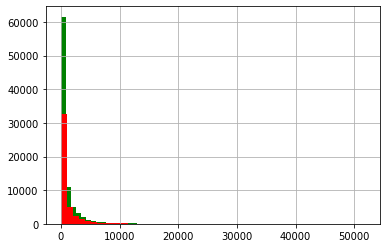

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def entries_histogram(turnstile_weather):
        
    plt.figure()
    
    # your code here to plot a histogram for hourly entries when it is not raining
    turnstile_weather[turnstile_weather['rain']==0]['ENTRIESn_hourly'].hist(bins=50,color="g")
    
    # your code here to plot a historgram for hourly entries when it is raining
    turnstile_weather[turnstile_weather['rain']==1]['ENTRIESn_hourly'].hist(bins=50,color="r")
 
    return plt

df = pd.read_csv(r"turnstile_data_master_with_weather.csv")
entries_histogram(df).show()

The above graph represents - This distribution is highly right-skewed for both the cases. Hourly entries are significantly higher when it doesn't rain. It means more people use the subway when the sky is clear.

Funtions below represents -

1. The mean of entries when it's raining
2. The mean of entries when it's not raining




In [33]:
import numpy as np
import pandas

def means(turnstile_weather):
        
    with_rain = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 1]
    without_rain = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 0]
    
    with_rain_mean = np.mean(with_rain)
    without_rain_mean = np.mean(without_rain)
    ### YOUR CODE HERE ###
    
    return with_rain_mean, without_rain_mean # leave this line for the grader

df = pd.read_csv(r"turnstile_data_master_with_weather.csv")
print(means(df))

## Map Reduce

Mapper -For each entry line, the mapper exit will PRINT (not return) UNIT as a key, and the number of ENTRIESn_hourly as the value. We'll separate the key and the value with a tab. For example: 'R002 \ t105105.0'


In [34]:
import sys

def mapper():
    for line in sys.stdin:
        data = line.strip().split(',')
        if(data[1] != 'UNIT' and len(data) == 22):
            print('{0}\t{1}'.format(data[1], data[6]))


sys.stdin = open('turnstile_data_master_with_weather.csv')
sys.stdout = open('mapper_result.txt', 'w')
mapper()

Reducer -
Given the mapper result from the previous exercise, the reducer must print (not return) one line per UNIT, with the total number of ENTRIESn_hourly during May (which is our data duration), separated by a tab. An example of exit line from the reducer may look like this: 'R001 \ t500625.0'

We can assume that the entry for the reducer is ordered in a way that all lines corresponding to a particular unit are grouped. However, the reducer exit will have repetition, as there are stores that appear in different files' locations.

Export your reducer into a file named reducer_result.txt and send it with your submission.

In [35]:
def reducer():
    old_unit = None
    for line in sys.stdin:
        data = line.strip().split('\t')
        if len(data) != 2:
            # Something is wrong. Skip this line.
            continue
            
        # same unit
        if old_unit and data[0]==old_unit:
            count += float(data[1])
            
        # new unit
        else:
            # not the first unit
            if old_unit:
                print('{0}\t{1}'.format(old_unit,count))
            
            # reset the unit and count
            old_unit = data[0]
            count = float(data[1])
            
    # print the final unit and count
    if old_unit:
        print('{0}\t{1}'.format(old_unit,count))


sys.stdin = open('mapper_result.txt')
sys.stdout = open('reducer_result.txt', 'w')        
reducer()

Conclusion
We compared the hourly trends for Subway user when it rains vs when it doesn't rain. From the graph above, it looks like both distributions are skewed and on an average more people use subway when sky is clear.

Then we used Hadoop Streaming to perform a MapReduce job in Python. Mapper function return the number of hourly entries for every unit.

And since the keys are already sorted in sys.stdin when passing to mapper(), there is no need to perform the intermediate shuffle sort step. All we have to do is pass the output of mapper() to reducer(). Reducer performs aggregated sum for each key.

The result is a single value for every key(unit in this case for every turnstile interactions with subway users).